In [58]:
from warnings import filterwarnings
filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv('train_titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
m = df.isna().sum()
m[m>0]

Age         177
Cabin       687
Embarked      2
dtype: int64

### Seperate X and Y

In [5]:
x = df.drop(columns=['PassengerId','Name','Ticket','Cabin','Survived'])
y = df[['Survived']]

In [7]:
x.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [8]:
y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


### Cat and Con seperation

In [9]:
cat = list(x.columns[x.dtypes == "object"])
con = list(x.columns[x.dtypes != "object"])

In [10]:
cat

['Sex', 'Embarked']

In [11]:
con

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

### Create a Pipeline for feature Selection

In [14]:
num_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                           ('scaler', StandardScaler())])

cat_pipe = Pipeline(steps=[('impute' , SimpleImputer(strategy='most_frequent')),
                           ('ordinal', OrdinalEncoder())])

# Combine both of them
pre = ColumnTransformer([('num', num_pipe, con),
                         ('cat', cat_pipe, cat)]).set_output(transform='pandas')

In [15]:
pre

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder())]),
                                 ['Sex', 'Embarked'])])

In [16]:
x_pre = pre.fit_transform(x)
x_pre.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex,cat__Embarked
0,0.827377,-0.565736,0.432793,-0.473674,-0.502445,1.0,2.0
1,-1.566107,0.663861,0.432793,-0.473674,0.786845,0.0,0.0
2,0.827377,-0.258337,-0.474545,-0.473674,-0.488854,0.0,2.0
3,-1.566107,0.433312,0.432793,-0.473674,0.420730,0.0,2.0
4,0.827377,0.433312,-0.474545,-0.473674,-0.486337,1.0,2.0


### Perform feature selection with mutual information scores

In [18]:
mic = mutual_info_classif(x_pre, y)
mic

array([0.05240508, 0.03443966, 0.03310247, 0.01100659, 0.1165007 ,
       0.15683615, 0.        ])

In [19]:
mic = pd.Series(mic)
mic.index = x_pre.columns
mic = mic.sort_values(ascending=False)
mic

cat__Sex         0.156836
num__Fare        0.116501
num__Pclass      0.052405
num__Age         0.034440
num__SibSp       0.033102
num__Parch       0.011007
cat__Embarked    0.000000
dtype: float64

<Axes: title={'center': 'Mutual Information Score'}>

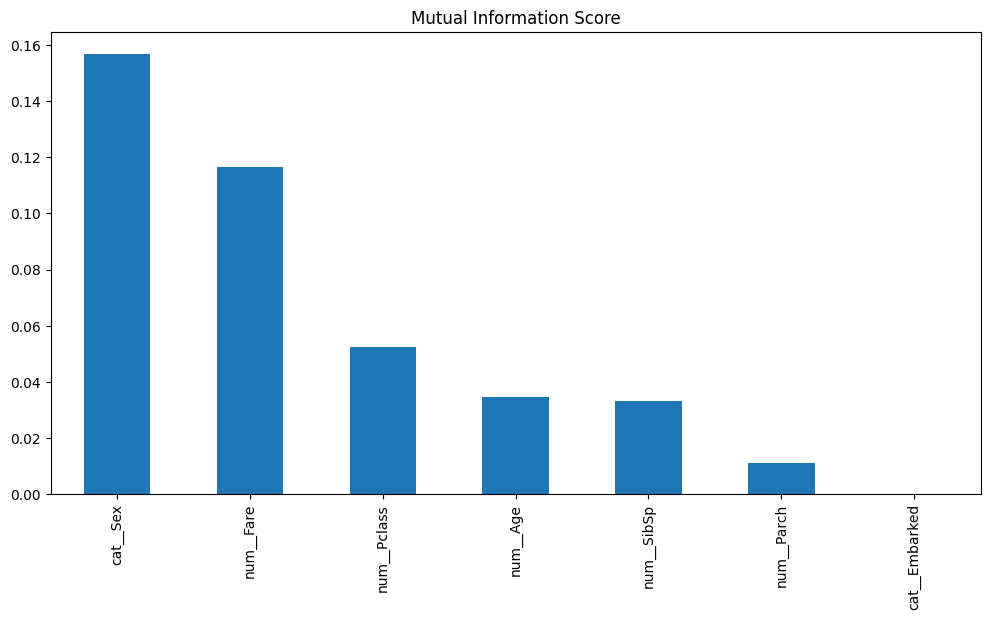

In [20]:
mic.plot(kind='bar', title='Mutual Information Score', figsize=(12,6))

### Select Top 5 feature

In [34]:
sel = SelectKBest(mutual_info_classif, k=5)
sel.fit(x_pre, y)
sel_cols = sel.get_feature_names_out()
sel_cols

array(['num__Pclass', 'num__Age', 'num__SibSp', 'num__Fare', 'cat__Sex'],
      dtype=object)

### get the original column names

In [35]:
sel_cols[0].split('__')


['num', 'Pclass']

In [36]:
sel_cols[0].split('__')[1]

'Pclass'

In [37]:
imp_cols = []
for i in sel_cols:
    s = i.split('__')[1]
    imp_cols.append(s)

In [38]:
imp_cols

['Pclass', 'Age', 'SibSp', 'Fare', 'Sex']

In [39]:
x_imp = x[imp_cols]
x_imp

,Pclass,Age,SibSp,Fare,Sex
0,3,22.0,1,7.2500,male
1,1,38.0,1,71.2833,female
2,3,26.0,0,7.9250,female
3,1,35.0,1,53.1000,female
4,3,35.0,0,8.0500,male
...,...,...,...,...,...
886,2,27.0,0,13.0000,male
887,1,19.0,0,30.0000,female
888,3,NaN,1,23.4500,female
889,1,26.0,0,30.0000,male


### Seperate cat and con for selected columns

In [40]:
cat_sel = list(x_imp.columns[x_imp.dtypes=='object'])
con_sel = list(x_imp.columns[x_imp.dtypes!='object'])

In [41]:
cat_sel

['Sex']

In [42]:
con_sel

['Pclass', 'Age', 'SibSp', 'Fare']

### create a Final preprocessing pipeline

In [53]:
num_pipe2 = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])

cat_pipe2 = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

pre2 = ColumnTransformer([('num', num_pipe2, con_sel),
                          ('cat', cat_pipe2, cat_sel)]).set_output(transform='pandas')

In [54]:
x_sel_pre = pre2.fit_transform(x_imp)
x_sel_pre.head()

,num__Pclass,num__Age,num__SibSp,num__Fare,cat__Sex_female,cat__Sex_male
0,0.827377,-0.565736,0.432793,-0.502445,0.0,1.0
1,-1.566107,0.663861,0.432793,0.786845,1.0,0.0
2,0.827377,-0.258337,-0.474545,-0.488854,1.0,0.0
3,-1.566107,0.433312,0.432793,0.420730,1.0,0.0
4,0.827377,0.433312,-0.474545,-0.486337,0.0,1.0


### Apply Train and Test Split on x_sel_pre

In [55]:
xtrain, xtest, ytrain, ytest = train_test_split(x_sel_pre, y, test_size=0.2, random_state=21)

In [56]:
xtrain.shape

(712, 6)

In [57]:
xtest.shape

(179, 6)

### create a Logistic regression algorithm

In [59]:
model = LogisticRegression()
model.fit(xtrain, ytrain)

LogisticRegression()

In [61]:
model.score(xtrain, ytrain)

0.7879213483146067

In [60]:
model.score(xtest, ytest)

0.8100558659217877

### predict result for train and test

In [62]:
ypred_tr = model.predict(xtrain)
ypred_ts = model.predict(xtest)

In [63]:
ypred_tr[0:5]

array([1, 1, 1, 1, 0], dtype=int64)

In [64]:
ytrain.head()

,Survived
793,0
23,1
97,1
9,1
157,0


In [65]:
ypred_ts[0:5]

array([1, 0, 0, 0, 0], dtype=int64)

In [66]:
ytest.head()

,Survived
617,0
379,0
725,0
826,0
450,0


In [67]:
c = model.classes_
c

array([0, 1], dtype=int64)

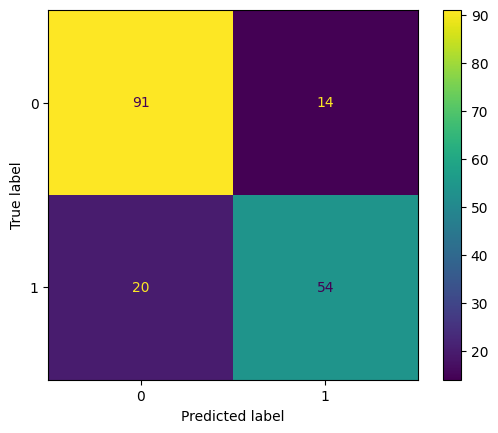

In [68]:
cf = confusion_matrix(ytest, ypred_ts)
cfd = ConfusionMatrixDisplay(cf, display_labels=c)
cfd.plot()

In [69]:
print(classification_report(ytest, ypred_ts))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       105
           1       0.79      0.73      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



### predict result out of sample data

In [70]:
xnew = pd.read_csv("test_titanic.csv")
xnew.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [71]:
pre2

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'Age', 'SibSp', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Sex'])])

In [72]:
xnew_pre = pre2.transform(xnew)
xnew_pre.head()

,num__Pclass,num__Age,num__SibSp,num__Fare,cat__Sex_female,cat__Sex_male
0,0.827377,0.394887,-0.474545,-0.490783,0.0,1.0
1,0.827377,1.355510,0.432793,-0.507479,1.0,0.0
2,-0.369365,2.508257,-0.474545,-0.453367,0.0,1.0
3,0.827377,-0.181487,-0.474545,-0.474005,0.0,1.0
4,0.827377,-0.565736,0.432793,-0.401017,1.0,0.0


### predict the result and probalility

In [73]:
preds = model.predict(xnew_pre)
preds

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [74]:
model.classes_

array([0, 1], dtype=int64)

In [75]:
prob = model.predict_proba(xnew_pre)[:,1]
prob[0:5]

array([0.08277458, 0.37176641, 0.09040981, 0.1056982 , 0.59323608])

In [76]:
df_final = xnew[['PassengerId']]
df_final

,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


In [77]:
df_final['Survived_pred'] = preds
df_final['Survived_prob'] = prob

In [78]:
df_final

,PassengerId,Survived_pred,Survived_prob
0,892,0,0.082775
1,893,0,0.371766
2,894,0,0.090410
3,895,0,0.105698
4,896,1,0.593236
...,...,...,...
413,1305,0,0.102296
414,1306,1,0.910719
415,1307,0,0.072476
416,1308,0,0.102296


In [79]:
df_final.to_csv('Titanic_Survived_Prediction.csv', index=False)

In [80]:
# Plot Graph of Survived
df_final['Survived_pred'].value_counts()

Survived_pred
0    261
1    157
Name: count, dtype: int64

<Axes: xlabel='Survived_pred'>

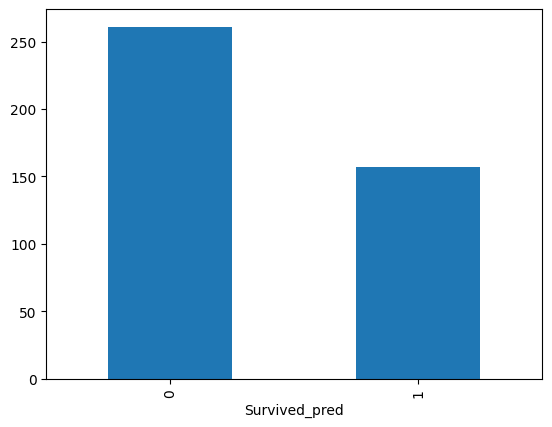

In [81]:
df_final['Survived_pred'].value_counts().plot(kind='bar')